# Size and Value in China

本文股票样本选取我国A股股票。剔除了市值最小30%、上市六个月以内、过去一个月不足15个交易日、过去12个月不足120个交易日的股票。
时间区间为2000年1月至2016年12月共204个月的月度数据为样本。
原文数据来源为wind数据库，复制采用CSMAR数据库数据。
无风险收益率采用人民银行公布的人民币一年定期存款利率。
月度收益率采用考虑现金红利再投资的月度收益率。

本文在每月月初分组：根据上个月月末的流通市值（size）分成两组；根据上个月月末的总市值和最新可得的净利润构建市盈率倒数指标（ep）分成三组，构建SMB和VMG因子。

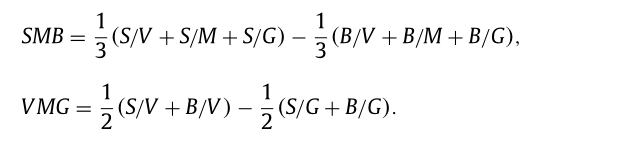

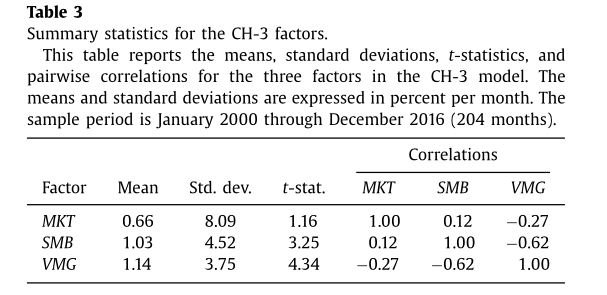
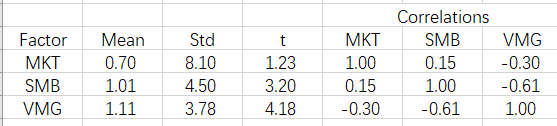

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import os,glob
import scipy.stats as st
import statsmodels.formula.api as smf
pd.set_option('display.width', 5000)

In [2]:
ret = pd.read_csv('月超额收益率.csv',header=0,index_col = 0)   #导入收益率（已剔除最小市值30%）
ret=ret[ret.index>200000]

beta=pd.read_csv('beta.csv',header=0,index_col =0) #beta
me=pd.read_csv('me.csv',header=0,index_col =0)  #市值
logme=np.log(me) 
bm=pd.read_csv('bm.csv',header=0,index_col =0) #账面市值比
logbm=np.log(bm) 
logbm[logbm==np.inf]=np.nan
logbm[logbm==-np.inf]=np.nan
am=pd.read_csv('am.csv',header=0,index_col =0) #资产市值比
logam=np.log(am) 
logam[logam==np.inf]=np.nan
logam[logam==-np.inf]=np.nan
ep=pd.read_csv('ep.csv',header=0,index_col =0)  #市盈率倒数
ep1=ep[ep.index>200000]
ep1[ep1<0]=0
ep0=ep[ep.index>200000]
ep0[ep0>0]=0
ep0[ep0<0]=1
cp=pd.read_csv('cp.csv',header=0,index_col =0)  #现金价格比
cp1=cp[cp.index>200000]
cp1[cp1<0]=0
cp0=cp[cp.index>200000]
cp0[cp0>0]=0
cp0[cp0<0]=1

D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
D:\anaconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\anaconda\lib\site-packages\pandas\core\frame.py:3530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value

In [ ]:
#fm回归
def fm_test(X1,X_list,ret,blank1,blank2):
    months=ret.index
    fm_result=pd.DataFrame(index=months,columns=list(range(2+len(X_list)+2)))
   
    for m,month in enumerate(months):
        final=pd.concat([ret.loc[month],X1.loc[month]],join='inner',axis=1)
        if len(X_list)>0:
            for X0 in X_list:
                final=pd.concat([final,X0.loc[month]],join='inner',axis=1)
        final = final.dropna()
        if len(final)>0:      
            model = sm.OLS(final.iloc[:, 0],sm.add_constant(final.iloc[:, 1:])).fit()  # 回归
            fm_result.iloc[m,0:-2]=model.params.values
            fm_result.iloc[m,-2]=model.rsquared_adj
            fm_result.iloc[m,-1]=len(final)
        else: 
            fm_result.iloc[m,:]=np.nan

    fm_result2=pd.DataFrame(index=list(range(10*2)),columns=['0'])  
    for j in range(fm_result.shape[1]):
        if j <fm_result.shape[1]-2:
            fm_result2.iloc[2*j,0]=round(fm_result.iloc[:,j].mean(), 4)
            fm_result2.iloc[2*j+1,0]='('+str(round(stats.ttest_1samp(fm_result.iloc[:,j].dropna(),0)[0],2))+')'
        else:
            fm_result2.iloc[-2,0]=round(fm_result.iloc[:,-2].mean(), 4) #adj_R2
            fm_result2.iloc[-1,0]=round(fm_result.iloc[:,-1].mean(), 0) #n

    return fm_result2

In [ ]:
tb1=fm_test(beta,[],ret,0,14)
tb2=fm_test(logme,[],ret,0,14)
tb3=fm_test(beta,[logme],ret,0,12)
tb4=fm_test(beta,[logme,logbm],ret,0,10)
tb5=fm_test(beta,[logme,logam],ret,0,10)
tb6=fm_test(beta,[logme,ep1,ep0],ret,0,8)
tb7=fm_test(beta,[logme,cp1,cp0],ret,0,8)
tb8=fm_test(beta,[logme,logbm,logam,ep1,ep0,cp1,cp0],ret,0,0)
tb9=fm_test(beta,[logme,logbm,ep1,ep0],ret,0,6)
           
fm=pd.concat([tb1,tb2,tb3,tb4,tb5,tb6,tb7,tb8,tb9],join='inner',axis=1)
fm.columns=['(1)','(2)','(3)','(4)','(5)','(6)','(7)','(8)','(9)']
index2=['intecept',np.nan, 'beta',np.nan,'logME',np.nan,'logBM',np.nan,'logAM',np.nan,'EP+',np.nan,
            'D(EP<0)', np.nan,'CP+',np.nan,'D(CP<0)',np.nan,'R2','n']      
fm.index=index2
fm.iloc[4:6,1]=fm.iloc[2:4,1].values
fm.iloc[2:4,1]=np.nan
fm.iloc[8:10,4]=fm.iloc[6:8,4].values
fm.iloc[6:8,4]=np.nan
fm.iloc[10:14,5]=fm.iloc[6:10,5].values
fm.iloc[6:10,5]=np.nan
fm.iloc[14:18,6]=fm.iloc[6:10,6].values
fm.iloc[6:10,6]=np.nan
fm.iloc[10:14,8]=fm.iloc[8:12,8].values
fm.iloc[8:10,8]=np.nan
fm = fm.replace(np.nan,'')
fm.to_csv('table2.csv')

In [6]:
table2=pd.read_csv('table2.csv',header=0,index_col =0)
table2 = table2.replace(np.nan,'')
print(table2)

             (1)      (2)      (3)      (4)      (5)      (6)      (7)      (8)      (9)
intecept  0.0114   0.0475   0.0538   0.0644   0.0605   0.0705   0.0548   0.0742   0.0738
NaN        (1.4)   (1.79)   (1.99)   (2.54)   (2.38)    (2.9)   (2.04)   (3.21)   (3.17)
beta      0.0006           -0.0021  -0.0036  -0.0023  -0.0012  -0.0018  -0.0017  -0.0019
NaN       (0.12)           (-0.46)   (-0.8)  (-0.53)  (-0.25)  (-0.39)  (-0.36)  (-0.42)
logME             -0.0022  -0.0024  -0.0026  -0.0027  -0.0038  -0.0026  -0.0037  -0.0036
NaN               (-1.36)  (-1.46)  (-1.62)  (-1.72)  (-2.64)  (-1.55)   (-2.8)  (-2.63)
logBM                                0.0051                              0.0025   0.0039
NaN                                  (3.18)                              (2.28)   (2.44)
logAM                                         0.0033                     0.0011         
NaN                                            (2.4)                     (0.97)         
EP+                  

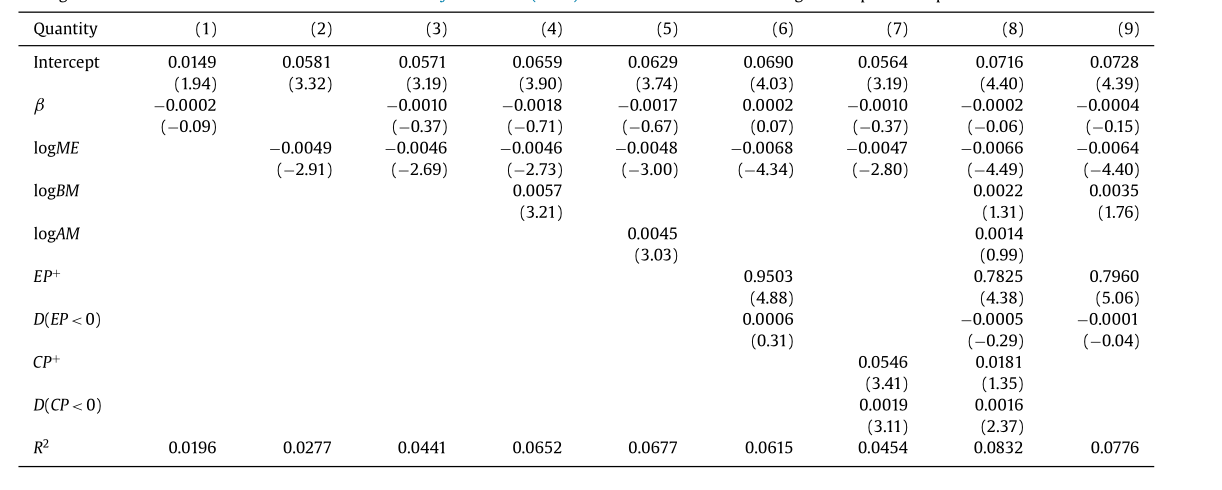

In [ ]:
#计算CH3因子
def get_ch3(ret,me,ep):
    months=ret.index
    fac=pd.DataFrame(columns=['mkt','smb','vmg'],index=ret.index)
    
    for i,month in enumerate(months):
        print(month)
        total=pd.concat([me.loc[month],ep.loc[month],ret.loc[month]],join='inner',axis=1)
        total.columns=['me','ep','ret']
        total=total.dropna()
        
        if len(total)<6:
            fac.iloc[i,:]=np.nan
        else:
            total['VW'] = total.apply(lambda x: x['me'] * x['ret'], axis=1) #VW=me*ret
            fac.iloc[i,0]=total['VW'].sum()/total['me'].sum()
            
            final = total.sort_values(by='me')  #根据me排序    
            S0 = final.iloc[:round(len(final)/2),:]#小
            B0 = final.iloc[round(len(final) / 2):,:]#大
            final = total.sort_values(by='ep') 
            G0=final.iloc[:round(len(final)/10*3),:]#小
            M0=final.iloc[round(len(final)/10*3):round(len(final)/10*7),:]
            V0=final.iloc[round(len(final)/10*7):,:]#大
            
            sg=pd.concat([S0,G0],join='inner',axis=1)
            sg=sg.iloc[:,:4]
            sm=pd.concat([S0,M0],join='inner',axis=1)
            sm=sm.iloc[:,:4]
            sv=pd.concat([S0,V0],join='inner',axis=1)
            sv=sv.iloc[:,:4]
            bg=pd.concat([B0,G0],join='inner',axis=1)
            bg=bg.iloc[:,:4]
            bm=pd.concat([B0,M0],join='inner',axis=1)
            bm=bm.iloc[:,:4]
            bv=pd.concat([B0,V0],join='inner',axis=1)
            bv=bv.iloc[:,:4]
    
            sgvw=sg['VW'].sum()/sg['me'].sum()
            smvw=sm['VW'].sum()/sm['me'].sum()
            svvw=sv['VW'].sum()/sv['me'].sum()
            bgvw=bg['VW'].sum()/bg['me'].sum()
            bmvw=bm['VW'].sum()/bm['me'].sum()
            bvvw=bv['VW'].sum()/bv['me'].sum()
    
            fac.iloc[i, 1] = (sgvw +smvw+svvw)/3-(bgvw+bmvw+bvvw)/3
            fac.iloc[i, 2] = (svvw +bvvw)/2-(sgvw+bgvw)/2
    fac=fac.astype(float)
    return fac

#三因子描述性统计
def get_tb3(ch3):
    table3=pd.DataFrame(index=[np.nan,'Factor','MKT','SMB','VMG'],columns=list(range(6)))
    table3.iloc[0,4]='Correlations'
    table3.iloc[1,:]=['Mean',  'Std', 't','MKT',  'SMB',  'VMG']
    for i in range(3):
        # i=0
        x=ch3.iloc[:,i].dropna()
        table3.iloc[i+2,0]= round(100*np.mean(x),2)   
        table3.iloc[i+2,1]= round(100*np.std(x),2)
        table3.iloc[i+2,2]=round(stats.ttest_1samp(x,0)[0] ,2)
    table3.iloc[2:,3:]=round(ch3.corr(),2).values  
    return table3

In [ ]:
#CH三因子
ch3=get_ch3(ret,me,ep)
table3=get_tb3(ch3)
table3.to_csv('table3.csv')

In [7]:
table3=pd.read_csv('table3.csv',header=0,index_col =0)
table3 = table3.replace(np.nan,'')
print(table3)

           0     1     2      3             4      5
NaN                              Correlations       
Factor  Mean   Std     t    MKT           SMB    VMG
MKT     0.79  8.45  1.32    1.0          0.11  -0.26
SMB     0.91  4.12  3.12   0.11           1.0  -0.59
VMG     1.05  3.92  3.77  -0.26         -0.59    1.0


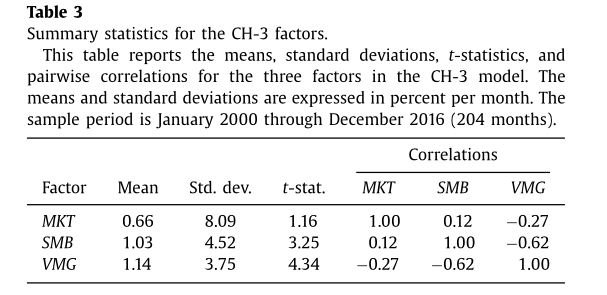

In [ ]:
#FF三因子
ff3=get_ch3(ret,me,bm)
ff3.columns=['mkt','ffsmb','ffhml']

In [ ]:
ret_all=pd.read_csv('月超额收益率all.csv',header=0,index_col = 0)   #导入全部股票收益率
ret_all=ret_all[ret_all.index>200000]

#计算R2
def get_tb4(ret,ch3):
    def get_R2(x,z):
        df=pd.concat([x,z],join='inner',axis=1,sort=False)
        df=df.dropna()
        if len(df)>0:      
            model = sm.OLS(df.iloc[:, 0],sm.add_constant(df.iloc[:, 1:])).fit()  # 回归
            R2=model.rsquared_adj
        else: 
            R2=np.nan  
        return R2
    
    R21=ret.apply(get_R2,z=ch3.iloc[:,1])    
    R22=ret.apply(get_R2,z=ch3.iloc[:,[1,2]]) 
    R23=ret.apply(get_R2,z=ch3.iloc[:,[1,3]])     
    R24=ret.apply(get_R2,z=ch3.iloc[:,1:]) 
    
    table4=pd.DataFrame(index=list(range(5)),columns=['Factor','R2'])
    table4.iloc[1:,0]=['MKT','MKT,SMB','MKT,VMG','MKT,SMB,VMG']
    table4.iloc[1:,1]=[R21.mean(),R22.mean(),R23.mean(),R24.mean()]
    
    return table4


In [ ]:
tb4_1=get_tb4(ret_all,ch3)
tb4_2=get_tb4(ret,ch3)
table4=pd.concat([tb4_1,tb4_2],join='outer',axis=0,sort=False)
table4.iloc[0,0]='Panel A: All individual stocks in China'
table4.iloc[5,0]='Panel B: All but the smallest 30% of stocks in China'
table4.to_csv('table4.csv')

In [12]:
table4=pd.read_csv('table4.csv',header=0,index_col =0)
table4 = table4.replace(np.nan,'')
print(table4)

                                              Factor        R2
0            Panel A: All individual stocks in China          
1                                                MKT  0.378941
2                                            MKT,SMB  0.491868
3                                            MKT,VMG  0.462676
4                                        MKT,SMB,VMG  0.505156
0  Panel B: All but the smallest 30% of stocks in...          
1                                                MKT   0.38323
2                                            MKT,SMB  0.482838
3                                            MKT,VMG  0.457012
4                                        MKT,SMB,VMG  0.496816


In [ ]:
# Abilities of models CH-3 and FF-3 to explain each other’s size and value factors.
def get_tb5_1(x,y):
    df=pd.concat([x,y],join='inner',axis=1,sort=False)   
    df=df.dropna()
    if len(df)>0:      
        model = sm.OLS(df.iloc[:, -1],sm.add_constant(df.iloc[:, :-1])).fit()  # 回归
        return [model.params[0],model.tvalues[0]]
    else :
        return [np.nan]*2
    
factor3=pd.concat([ch3,100*ff3],join='inner',axis=1,sort=False)
factor3=factor3.iloc[:,[1,2,3,5,6]]    
factor3=factor3.fillna(0)

table5=pd.DataFrame(index=list(range(14)),columns=['Factors'  ,'CH-3',  'FF-3'])
table5.iloc[:,0]=['Panel A: Alpha(t)','FFSMB',np.nan,'FFHML',np.nan,'SMB',np.nan,'VMG',np.nan,'Panel B: GRS F(p)','FFSMB,FFHML',np.nan,'SMB,VMG',np.nan]

table5.iloc[1:3,1]=get_tb5_1(factor3[['mkt','smb','vmg']],factor3['ffsmb'])
table5.iloc[3:5,1]=get_tb5_1(factor3[['mkt','smb','vmg']],factor3['ffhml'])
table5.iloc[5:7,2]=get_tb5_1(factor3[['mkt','ffsmb','ffhml']],factor3['smb'])
table5.iloc[7:9,2]=get_tb5_1(factor3[['mkt','ffsmb','ffhml']],factor3['vmg'])

In [ ]:
#GRS检验
def grs_test(fct,port):
    t=fct.shape[0] # 时间期数
    n=fct.shape[1]  # 资产个数
    l=port.shape[1]  # 因子组合个数
    
    alpha=pd.DataFrame(columns=['0'],index=list(range(n)))
    res=pd.DataFrame(columns=list(range(n)),index=port.index)
    r2=pd.DataFrame(columns=['0'],index=list(range(n)))
    
    for i in range(0,n):
        ols=pd.concat([fct.iloc[:,i],port],join='inner',axis=1,sort=False)
        ols=ols.dropna()
        reg = sm.OLS(ols.iloc[:, 0],sm.add_constant(ols.iloc[:, 1:])).fit()  
        alpha.iloc[i,0]=reg.params[0]
        res.iloc[:,i]=reg.resid
        r2.iloc[i,0]=reg.rsquared_adj
    
    state=np.asmatrix(port)
    alpha=np.asmatrix(alpha)
    res=np.asmatrix(res)
    r2=np.asmatrix(r2)
    
    sig=res.T @  res /(t-1-l) #残差协方差矩阵
    mean=state.mean(axis=0).T
    co=np.cov(state,rowvar=0) # co is a cov matrix of factor portfolios
    
    if l>1:
        grs=(t/n) * ((t-n-l)/(t-l-1)) * ( alpha.T  @ np.linalg.inv(sig) @ alpha) / (1+ mean.T @ np.linalg.inv(co) @ mean)
    elif co!=0:
        grs=(t/n) * ((t-n-l)/(t-l-1)) * ( alpha.T  @ np.linalg.inv(sig) @ alpha) / (1+ mean.T * 1/co * mean)
    else:
        grs=(t/n) * ((t-n-l)/(t-l-1)) * ( alpha.T  @ np.linalg.inv(sig) @ alpha) / (1)
    grs=float(grs) #grs值
    p_grs = 1 - st.f.cdf(grs, n, (t-n-l)) # grs的p值
    
    mean_alpha=np.mean(abs(alpha)) # 平均|a|
    sr_alpha=float(alpha.T  @ np.linalg.inv(sig) @ alpha )  # SR(alpha)
    
    return [grs,p_grs,mean_alpha,sr_alpha]

gch=grs_test(factor3[['mkt','ffsmb','ffhml']],factor3[['mkt','smb','vmg']])
gff=grs_test(factor3[['mkt','smb','vmg']],factor3[['mkt','ffsmb','ffhml']])

table5.iloc[10:12,1]=gch[0:2]
table5.iloc[12:14,2]=gff[0:2]
table5.to_csv('table5.csv')

In [9]:
table5=pd.read_csv('table5.csv',header=0,index_col =0)
table5 = table5.replace(np.nan,'')
print(table5)

              Factors        CH-3         FF-3
0   Panel A: Alpha(t)                         
1               FFSMB   0.0451231             
2                        0.406673             
3               FFHML    0.463676             
4                         1.32289             
5                 SMB                 0.476675
6                                      4.25895
7                 VMG                  1.40777
8                                      7.52577
9   Panel B: GRS F(p)                         
10        FFSMB,FFHML     5.07236             
11                     0.00209441             
12            SMB,VMG                  21.2453
13                                 5.66425e-12


In [ ]:
path = r'F:\指标'   #存储指标原数据的路径
file = glob.glob(os.path.join(path, "*.csv")) # 读取所有异象因子

k = []  
for i in range(len(file)):
    k.append(pd.read_csv(file[i],header=0,index_col = 0))

namelist = []  
for i in range(len(file)):
    namelist.append(file[i][33:-4])   #取因子名称

In [ ]:
# 异象因子多空收益组合
def get_group(indicator,size,ret):
    months=ret.index
    df = pd.DataFrame(columns=['vw'],index=ret.index)
    for m,month in enumerate(months):

        final=pd.concat([indicator.loc[month],size.loc[month],ret.loc[month]],join='inner',axis=1)
        final.columns=['factor','size','ret']
        final=final.dropna()
        if len(final)<=10:
            df.iloc[m,0]=np.nan
        else:
            final = final.sort_values(by='factor')
            final['VW'] = final.apply(lambda x: x['size'] * x['ret'], axis=1)
            
            df1=final.iloc[:round(len(final) / 10 ), :]
            df10=final.iloc[round(len(final) / 10*9):, :]

            df.iloc[m,0]=(df10['VW'].sum() / df10['size'].sum()) - ( df1['VW'].sum() / df1['size'].sum())
    df=pd.DataFrame(df,dtype=np.float)
    return df

def get_series(k,x,y,ret,size,namelist):
    fcvw=pd.DataFrame(index=ret.index)
    for i in range(x,y):
        z=get_group(k[i],size,ret)
        fcvw[i]=z['vw']
        print(i)
    name=namelist[x:y]
    fcvw.columns=name
    fcvw=fcvw.fillna(0)
    return fcvw

fcvw=get_series(k,0,10,ret,k[0],namelist) #十分位多空组合 

In [ ]:
#异象因子市值中性多空收益组合
def get_group_neutral(indicator,size,ret):
    months=ret.index
    df = pd.DataFrame(columns=['vw'],index=ret.index)
    for m,month in enumerate(months):

        final=pd.concat([indicator.loc[month],size.loc[month],ret.loc[month]],join='inner',axis=1)
        final.columns=['factor','size','ret']
        final=final.dropna()
        if len(final)<=10:
            df.iloc[m,0]=np.nan
        else:
            final['VW'] = final.apply(lambda x: x['size'] * x['ret'], axis=1)
            final = final.sort_values(by='size')       
            s=final.iloc[:round(len(final) /2), :]
            b=final.iloc[round(len(final) /2):, :]

            final = final.sort_values(by='factor')               
            f1=final.iloc[:round(len(final) / 10 ), :]
            f10=final.iloc[round(len(final) / 10*9):, :]
            
            sf1=pd.concat([s,f1],join='inner',sort=False)
            sf10=pd.concat([s,f10],join='inner',sort=False)
            bf1=pd.concat([b,f1],join='inner',sort=False)
            bf10=pd.concat([b,f10],join='inner',sort=False)
     
            df.iloc[m,0]=0.5*(sf10['VW'].sum() / sf10['size'].sum() + bf10['VW'].sum() / bf10['size'].sum()) -(sf1['VW'].sum() / sf1['size'].sum() + bf1['VW'].sum() / bf1['size'].sum()) 
    df=pd.DataFrame(df,dtype=np.float)
    return df

def get_series_neutral(k,x,y,ret,size,namelist):
    fcvw=pd.DataFrame(index=ret.index)
    # i=0
    for i in range(x,y):
        z=get_group_neutral(k[i],size,ret)
        fcvw[i]=z['vw']
        print(i)
    name=namelist[x:y]
    fcvw.columns=name
    fcvw=fcvw.fillna(0)
    return fcvw

fcvw_neutral=get_series_neutral(k,1,10,ret,k[0],namelist) #市值中性异象因子多空组合 

In [ ]:
#单因子检验
def task(vb,ff_factor): 
    vb=vb.dropna()
    vb=vb*100
    if np.mean(vb)<0:
        vb=-vb
    ff=ff_factor[['mkt']]
    vb2=pd.concat([vb,ff], axis=1, join='inner')
    vb2.columns=['factor','mkt_rf']    
    #均值
    a=round(np.mean(vb),2)
    #t检验
    t=round(stats.ttest_1samp(vb,0)[0],2)
    
    camp=smf.ols('factor~mkt_rf',vb2).fit(cov_type='HAC',cov_kwds={'maxlags':5})
    c_a=round(camp.params[0],2)
    c_b=round(camp.params[1],2)
    t_a=round(camp.tvalues[0],2)    
    t_b=round(camp.tvalues[1],2)           

    c=pd.DataFrame([vb.name,a,c_a,c_b,t,t_a,t_b],index=['Anomaly','R','α','β','t(R)','t(α)','t(β)'])
    c=c.T
    return c

def get_result(fcvw):
    result=pd.DataFrame(index=['0'],columns=['Anomaly','R','α','β','t(R)','t(α)','t(β)'])    
    for i in range(fcvw.shape[1]):
        x1=task(fcvw.iloc[:,i],factor3)
        result=pd.concat([result,x1],join='inner',axis=0,sort=False)  
    return result

In [ ]:
tb6a=get_result(fcvw)
tb6b=get_result(fcvw_neutral)
index0=['Panel A: Unconditional sorts','Size','Value','Value','Value','Profitability','Volatility','Volatility','Reversal',
        'Turnover','Turnover','Panel B: Size-neutral sorts','Value','Value','Value','Profitability','Volatility','Volatility',
        'Reversal','Turnover','Turnover']
table6=pd.concat([tb6a,tb6b],join='inner',axis=0,sort=False)
table6.index=index0
table6 = table6.replace(np.nan,'')
table6.to_csv('table6.csv')

In [14]:
table6=pd.read_csv('table6.csv',header=0,index_col =0)
table6 = table6.replace(np.nan,'')
print(table6)

                                  Anomaly     R     α     β  t(R)  t(α)   t(β)
Panel A: Unconditional sorts                                                  
Size                            marketcap  0.97  0.87  0.14  1.83  2.01   1.51
Value                                  ep  0.84  0.93 -0.12  1.79   2.6  -1.65
Value                                  bm  0.73  0.73     0  1.39  1.76   0.02
Value                                  cp  0.13  0.14 -0.02  0.51  0.75  -0.55
Profitability                         roe  0.63  0.72 -0.13  1.37  1.97   -1.5
Volatility                            vol   1.1  1.37 -0.38  2.23  2.83  -4.75
Volatility                            max  0.49  0.69 -0.28  1.41  2.26  -7.11
Reversal                              rev  0.96  1.01 -0.07  1.91  2.15  -0.97
Turnover                         turn_12m  0.21  0.41 -0.28  0.43  1.06   -3.7
Turnover                      turn_abn_1m  0.77  0.91 -0.19  1.81  2.36  -2.67
Panel B: Size-neutral sorts                         

In [ ]:
#CH3因子调整的异象收益
def taskch3(vb,ff_factor): 
    vb=vb.dropna()
    vb=vb*100
    if np.mean(vb)<0:
        vb=-vb
    ff=ff_factor[['mkt','smb','vmg']]
    vb2=pd.concat([vb,ff], axis=1, join='inner')
    vb2.columns=['factor','mkt_rf','smb','vmg']    
    
    ch3=smf.ols('factor~mkt_rf+smb+vmg',vb2).fit(cov_type='HAC',cov_kwds={'maxlags':5})
    c_a=round(ch3.params[0],2)
    c_b=round(ch3.params[1],2)
    c_c=round(ch3.params[2],2)
    c_d=round(ch3.params[3],2)  
    
    t_a=round(ch3.tvalues[0],2)    
    t_b=round(ch3.tvalues[1],2)           
    t_c=round(ch3.tvalues[2],2)    
    t_d=round(ch3.tvalues[3],2)  
    
    c=pd.DataFrame([vb.name,c_a,c_b,c_c,c_d,t_a,t_b,t_c,t_d],index=['Anomaly','α','β_MKT','β_SMB','β_VMG','t(α)','t(β_MKT)','t(β_SMB)','t(β_VMG)'])
    c=c.T
    return c

def get_result_ch3(fcvw):
    result=pd.DataFrame(index=['0'],columns=['Anomaly','α','β_MKT','β_SMB','β_VMG','t(α)','t(β_MKT)','t(β_SMB)','t(β_VMG)'])    
    for i in range(fcvw.shape[1]):
        # i=0
        x1=taskch3(fcvw.iloc[:,i],factor3)
        result=pd.concat([result,x1],join='inner',axis=0,sort=False)  
    return result

tb7a=get_result_ch3(fcvw)
tb7b=get_result_ch3(fcvw_neutral)
table7=pd.concat([tb7a,tb7b],join='inner',axis=0,sort=False)
table7.index=index0
table7 = table7.replace(np.nan,'')
table7.to_csv('table7.csv')

In [13]:
table7=pd.read_csv('table7.csv',header=0,index_col =0)
table7 = table7.replace(np.nan,'')
print(table7)

                                  Anomaly     α β_MKT β_SMB β_VMG  t(α) t(β_MKT) t(β_SMB) t(β_VMG)
Panel A: Unconditional sorts                                                                      
Size                            marketcap  0.29 -0.05   1.3 -0.54  1.62    -1.46    19.12    -7.69
Value                                  ep -0.11  0.09 -0.44  1.21 -0.44     2.29    -6.69    11.98
Value                                  bm   0.4  0.07 -0.16   0.4  0.65     0.68    -0.62     1.31
Value                                  cp  0.59     0 -0.37 -0.07  2.06     0.01    -3.65    -0.71
Profitability                         roe  -0.3  0.06 -0.37  1.13 -0.88     1.25    -3.33     8.22
Volatility                            vol  0.67 -0.26 -0.19  0.73  1.66    -3.52    -1.33     4.84
Volatility                            max  0.44 -0.23  -0.1  0.28  1.37    -5.86    -0.95        3
Reversal                              rev  0.15 -0.09  0.63  0.21  0.27    -1.41     3.83     0.97
Turnover  

In [ ]:
#FF3因子调整的异象收益
def taskff3(vb,ff_factor): 
    vb=vb.dropna()
    vb=vb*100
    if np.mean(vb)<0:
        vb=-vb
    ff=ff_factor[['mkt','ffsmb','ffhml']]
    vb2=pd.concat([vb,ff], axis=1, join='inner')
    vb2.columns=['factor','mkt_rf','ffsmb','ffhml']    
    
    ch3=smf.ols('factor~mkt_rf+ffsmb+ffhml',vb2).fit(cov_type='HAC',cov_kwds={'maxlags':5})
    c_a=round(ch3.params[0],2)
    c_b=round(ch3.params[1],2)
    c_c=round(ch3.params[2],2)
    c_d=round(ch3.params[3],2)  
    
    t_a=round(ch3.tvalues[0],2)    
    t_b=round(ch3.tvalues[1],2)           
    t_c=round(ch3.tvalues[2],2)    
    t_d=round(ch3.tvalues[3],2)  
    
    c=pd.DataFrame([vb.name,c_a,c_b,c_c,c_d,t_a,t_b,t_c,t_d],index=['Anomaly','α','β_MKT','β_FFSMB','FFHML','t(α)','t(β_MKT)','t(β_FFSMB)','t(FFHML)'])
    c=c.T
    return c

def get_result_ff3(fcvw):
    result=pd.DataFrame(index=['0'],columns=['Anomaly','α','β_MKT','β_FFSMB','FFHML','t(α)','t(β_MKT)','t(β_FFSMB)','t(FFHML)'])    
    for i in range(fcvw.shape[1]):
        # i=0
        x1=taskff3(fcvw.iloc[:,i],factor3)
        result=pd.concat([result,x1],join='inner',axis=0,sort=False)  
    return result

tb8a=get_result_ff3(fcvw)
tb8b=get_result_ff3(fcvw_neutral)
table8=pd.concat([tb8a,tb8b],join='inner',axis=0,sort=False)
table8.index=index0
table8 = table8.replace(np.nan,'')
table8.to_csv('table8.csv')

In [15]:
table8=pd.read_csv('table8.csv',header=0,index_col =0)
table8 = table8.replace(np.nan,'')
print(table8)

                                  Anomaly     α β_MKT β_FFSMB FFHML  t(α) t(β_MKT) t(β_FFSMB) t(FFHML)
Panel A: Unconditional sorts                                                                          
Size                            marketcap  0.12  0.03    1.65 -0.13  0.91     1.42      32.12     -2.1
Value                                  ep  1.45 -0.05   -1.19  0.14   7.3    -0.85     -15.69     2.16
Value                                  bm -0.42 -0.03   -0.04   1.6 -1.78     -0.8      -0.54    30.43
Value                                  cp  0.38     0   -0.34 -0.09  1.78     0.11      -3.18    -1.18
Profitability                         roe  1.56 -0.04   -1.17 -0.32  6.31    -0.68     -12.91    -3.26
Volatility                            vol  1.25 -0.35   -0.53  0.53  3.06    -6.04      -3.84     4.04
Volatility                            max  0.81 -0.26    -0.3  0.04  2.75    -7.08      -2.95      0.4
Reversal                              rev  0.36 -0.12    0.61  0.45  0.76

In [ ]:
#Comparing the abilities of models to explain anomalies.
def get_tb9(fcvw,port):    
    dt8_0=pd.DataFrame(index=list(range(7)),columns=['0'])
    dt8_1=pd.DataFrame(index=['alpha','t'],columns=list(range(fcvw.shape[1])))
    
    for i in range(fcvw.shape[1]):
        olsdf=pd.concat([100*fcvw.iloc[:,i],port],join='inner',axis=1,sort=False)
        reg = sm.OLS(olsdf.iloc[:, 0],sm.add_constant(olsdf.iloc[:, 1:])).fit()  
        dt8_1.iloc[0,i]=round(reg.params[0],2)
        dt8_1.iloc[1,i]=round(reg.tvalues[0],2)
    
    dt8_0.iloc[1,0]=np.mean(abs(dt8_1.iloc[0,:])) # 平均alpha
    dt8_0.iloc[2,0]=np.mean(abs(dt8_1.iloc[1,:]))    #平均t
    
    g1=grs_test(fcvw,port)
    g2=grs_test(fcvw.iloc[:,3:],port)
    
    dt8_0.iloc[3:5,0]=g1[0:2] 
    dt8_0.iloc[5:7,0]=g2[0:2] 
    
    return dt8_0 

In [ ]:
port0=pd.DataFrame(0,index=fcvw.index,columns=['0'])
tb9_1=get_tb9(fcvw,port0)
tb9_2=get_tb9(fcvw,pd.DataFrame(factor3['mkt']))
tb9_3=get_tb9(fcvw,factor3[['mkt','ffsmb','ffhml']])
tb9_4=get_tb9(fcvw,factor3[['mkt','smb','vmg']])   

table9A=pd.concat([tb9_1,tb9_2,tb9_3,tb9_4],join='inner',axis=1)
table9A.columns=['Unadjusted',  'CAPM',  'FF-3',  'CH-3']

tb9_1=get_tb9(fcvw_neutral,port0)
tb9_2=get_tb9(fcvw_neutral,pd.DataFrame(factor3['mkt']))
tb9_3=get_tb9(fcvw_neutral,factor3[['mkt','ffsmb','ffhml']])
tb9_4=get_tb9(fcvw_neutral,factor3[['mkt','smb','vmg']])   

table9B=pd.concat([tb9_1,tb9_2,tb9_3,tb9_4],join='inner',axis=1)
table9B.columns=['Unadjusted',  'CAPM',  'FF-3',  'CH-3']

table9=pd.concat([table9A,table9B],join='inner',axis=0)
table9.index=['Panel A: Unconditional sorts','Average |α|','Average |t|','GRS10','p10','GRS7','p7' ,
             'Panel B: Size-neutral sorts','Average |α|','Average |t|','GRS9','p9','GRS6','p6' ] 
table9=table9.reset_index()
table9 = table9.replace(np.nan,'')
table9.to_csv('table9.csv')

In [16]:
table9=pd.read_csv('table9.csv',header=0,index_col =0)
table9 = table9.replace(np.nan,'')
print(table9)

                           index   Unadjusted         CAPM         FF-3      CH-3
0   Panel A: Unconditional sorts                                                 
1                    Average |α|        0.683        0.778        0.782     0.407
2                    Average |t|        1.468        1.748        2.547     1.119
3                          GRS10        5.095      5.43867      5.00498   1.23063
4                            p10  1.35922e-06  4.28085e-07  1.87282e-06  0.273628
5                           GRS7      2.64568      3.17301      6.11924   1.50337
6                             p7    0.0123386   0.00334375  1.79604e-06   0.16809
7    Panel B: Size-neutral sorts                                                 
8                    Average |α|     0.895556     0.227778     0.214444  0.117778
9                    Average |t|      1.47778     0.886667      1.26111  0.515556
10                          GRS9      1.73767      1.56524      3.86873  0.844684
11              

In [ ]:
turn_abn = pd.read_csv('ret_turn_abn.csv',header=0,index_col = 0)   #异常交易量 
ch4_turn=get_ch3(ret,me,turn_abn) #获取市值与异常交易交叉分组的因子（PMO）
ch4_turn.columns=['mkt1','smb1','pmo']
ch4=pd.concat([factor3,ch4_turn],join='inner',axis=1)
ch4=ch4[['mkt','smb','vmg','pmo']]
ch4=ch4.fillna(0)

In [ ]:
#CH4因子调整的异象收益
def taskch4(vb,ff_factor): 
    vb=vb.dropna()
    vb=vb*100
    if np.mean(vb)<0:
        vb=-vb
    ff=ff_factor[['mkt','smb','vmg','pmo']]
    vb2=pd.concat([vb,ff], axis=1, join='inner')
    vb2.columns=['factor','mkt_rf','smb','vmg','pmo']    
    
    ch3=smf.ols('factor~mkt_rf+smb+vmg+pmo',vb2).fit(cov_type='HAC',cov_kwds={'maxlags':5})
    c_a=round(ch3.params[0],2)
    c_b=round(ch3.params[1],2)
    c_c=round(ch3.params[2],2)
    c_d=round(ch3.params[3],2)  
    c_e=round(ch3.params[4],2) 
    
    t_a=round(ch3.tvalues[0],2)    
    t_b=round(ch3.tvalues[1],2)           
    t_c=round(ch3.tvalues[2],2)    
    t_d=round(ch3.tvalues[3],2)  
    t_e=round(ch3.tvalues[4],2) 
    
    c=pd.DataFrame([vb.name,c_a,c_b,c_c,c_d,c_e,t_a,t_b,t_c,t_d,t_e],index=['Anomaly','α','β_MKT','β_SMB','β_VMG','β_PMO','t(α)','t(β_MKT)','t(β_SMB)','t(β_VMG)','t(β_PMO)'])
    c=c.T
    return c

def get_result_ch4(fcvw):
    result=pd.DataFrame(index=['0'],columns=['Anomaly','α','β_MKT','β_SMB','β_VMG','β_PMO','t(α)','t(β_MKT)','t(β_SMB)','t(β_VMG)','t(β_PMO)'])    
    for i in range(fcvw.shape[1]):
        # i=0
        x1=taskch3(fcvw.iloc[:,i],factor3)
        result=pd.concat([result,x1],join='inner',axis=0,sort=False)  
    return result

tb10a=get_result_ch3(fcvw)
tb10b=get_result_ch3(fcvw_neutral)
table10=pd.concat([tb10a,tb10b],join='inner',axis=0,sort=False)
table10.index=index0
table10 = table10.replace(np.nan,'')
table10.to_csv('table10.csv')

In [17]:
table10=pd.read_csv('table10.csv',header=0,index_col =0)
table10 = table10.replace(np.nan,'')
print(table10)

                                  Anomaly     α β_MKT β_SMB β_VMG  t(α) t(β_MKT) t(β_SMB) t(β_VMG)
Panel A: Unconditional sorts                                                                      
Size                            marketcap  0.29 -0.05   1.3 -0.54  1.62    -1.46    19.12    -7.69
Value                                  ep -0.11  0.09 -0.44  1.21 -0.44     2.29    -6.69    11.98
Value                                  bm   0.4  0.07 -0.16   0.4  0.65     0.68    -0.62     1.31
Value                                  cp  0.59     0 -0.37 -0.07  2.06     0.01    -3.65    -0.71
Profitability                         roe  -0.3  0.06 -0.37  1.13 -0.88     1.25    -3.33     8.22
Volatility                            vol  0.67 -0.26 -0.19  0.73  1.66    -3.52    -1.33     4.84
Volatility                            max  0.44 -0.23  -0.1  0.28  1.37    -5.86    -0.95        3
Reversal                              rev  0.15 -0.09  0.63  0.21  0.27    -1.41     3.83     0.97
Turnover  